<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/Hydrogen_Prod1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

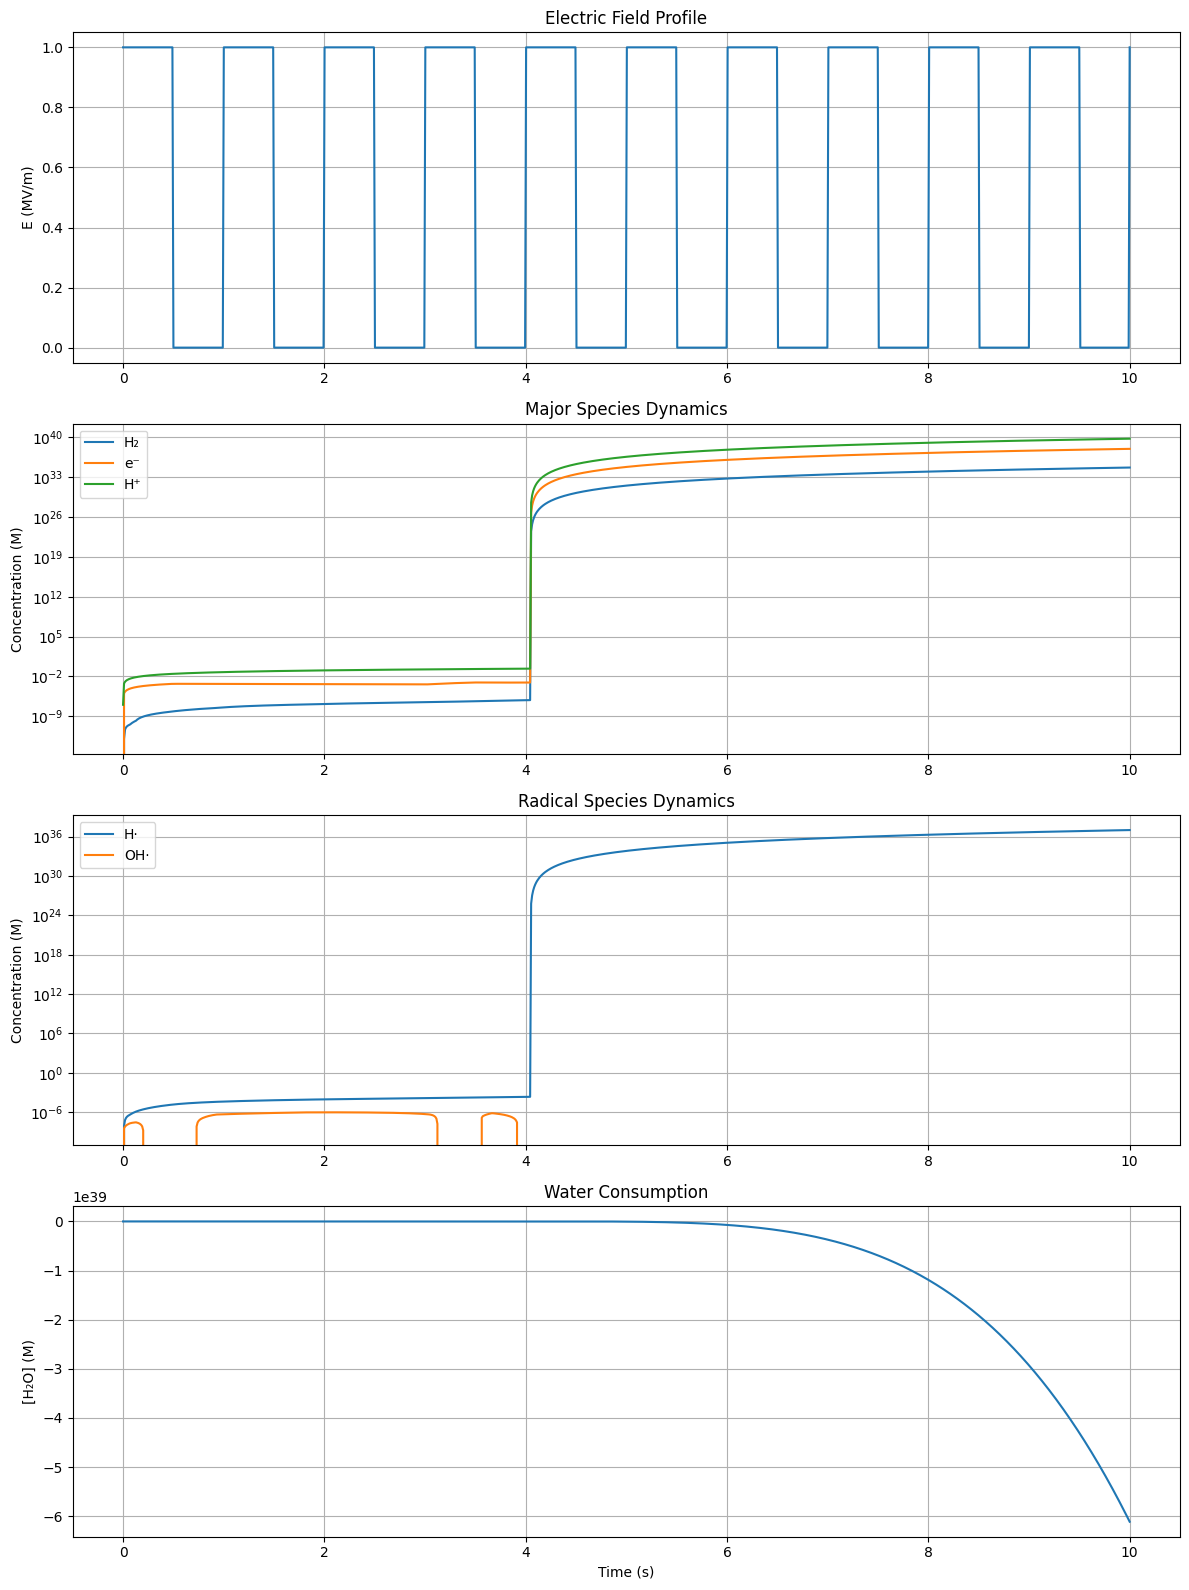

/usr/local/lib/python3.11/dist-packages/scipy/integrate/_ivp/common.py:356: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/usr/local/lib/python3.11/dist-packages/scipy/integrate/_ivp/common.py:378: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


Simulation completed successfully!


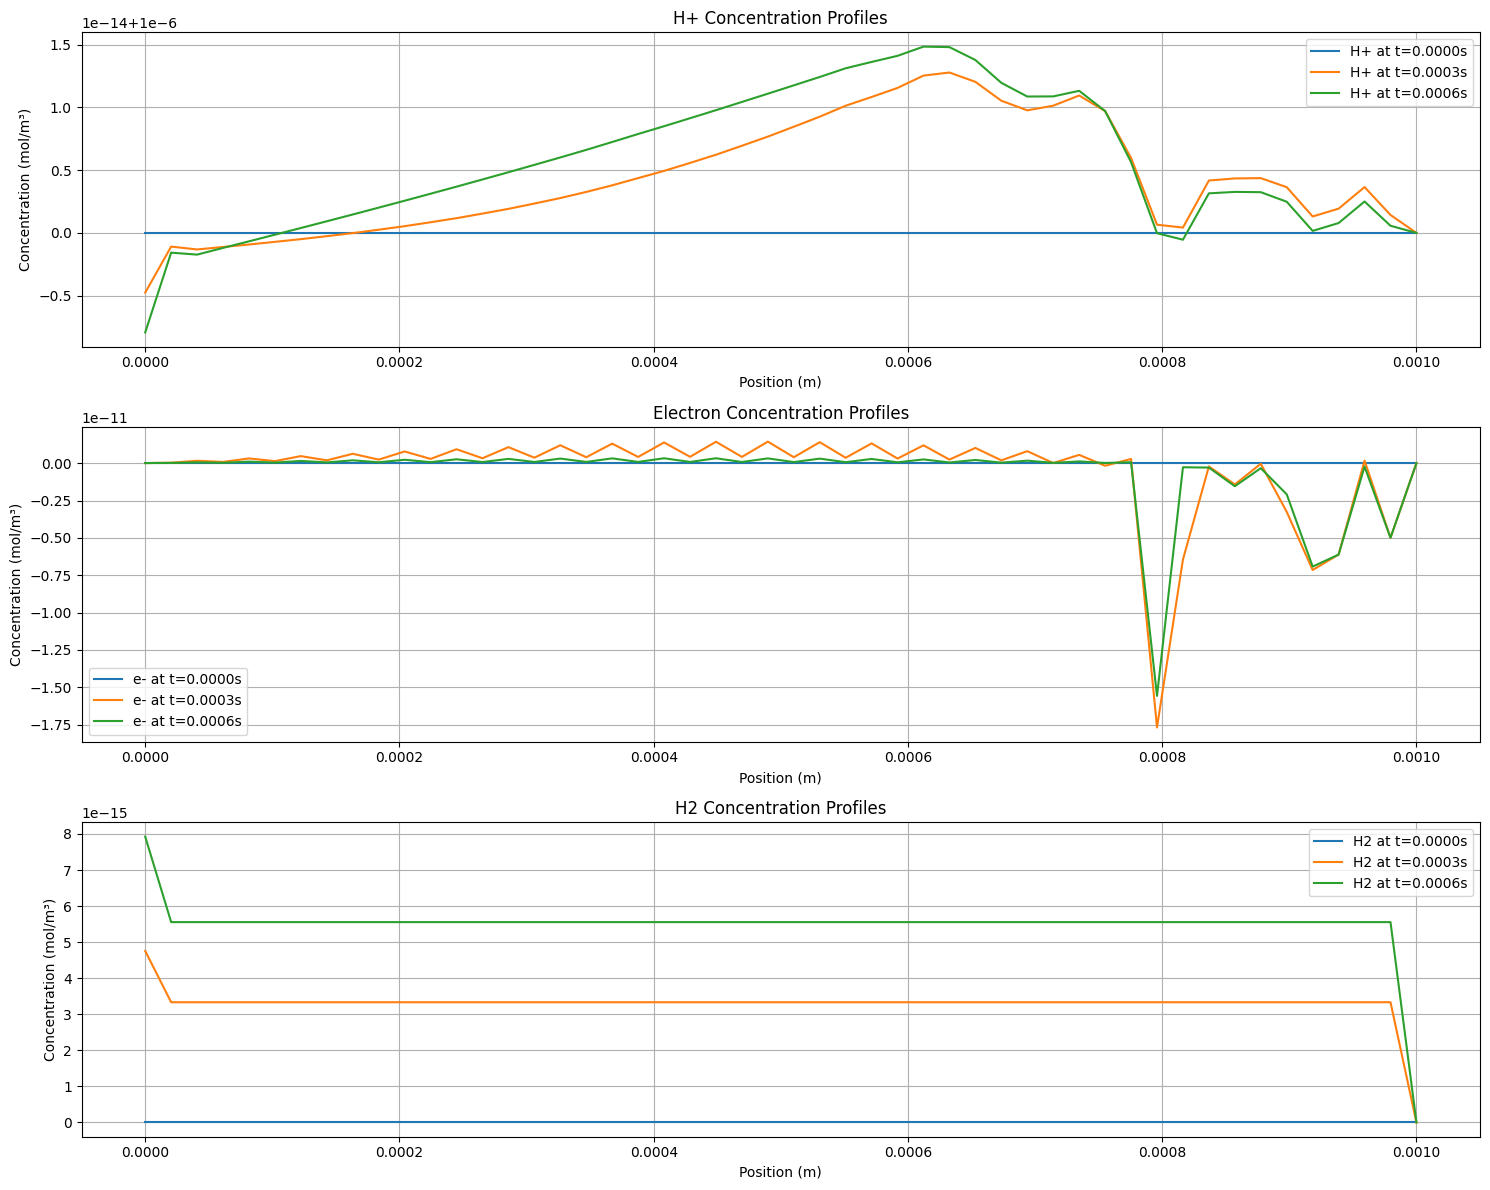

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
F = 96485  # C/mol
R = 8.314  # J/(mol·K)
T = 298  # K
d = 1e-9  # Double layer thickness (m)

# Model parameters
params = {
    # Baseline rate coefficients (1/s or 1/(M·s))
    'k1_0': 1e-3,       # Water dissociation
    'k2_0': 5e-3,       # H+ reduction (1/(M·s))
    'k3_0': 2e-3,       # OH· formation (1/(M·s))
    'k4': 1e-3,         # H· recombination (1/(M·s))
    'k5': 1e10,         # OH· recombination (1/(M·s))
    'k_gen': 1e-3,      # Electron generation rate (M/s)

    # Physical parameters
    'mu_H2O': 2.6e-30,  # Dipole moment (C·m)
    'alpha': 0.5,       # Charge transfer coefficient
    'z': 1,             # Ion charge

    # Pulse parameters
    'E0': 1e6,          # Peak electric field (V/m)
    'frequency': 1,     # Hz
    'duty_cycle': 0.5   # Fraction
}

def electric_field(t):
    """Square wave electric field"""
    period = 1/params['frequency']
    pulse_duration = period * params['duty_cycle']
    return params['E0'] if t % period < pulse_duration else 0

def dYdt(t, Y):
    """ODE system with field-dependent kinetics"""
    H2O, H_plus, OH_minus, H2, e_minus, H_rad, OH_rad = Y
    E = electric_field(t)

    # Field-modulated rate coefficients
    exponent = (params['alpha']*params['z']*F*E*d)/(R*T)
    k1 = params['k1_0'] * (1 + params['mu_H2O']*E)  # Enhanced dissociation
    k2 = params['k2_0'] * np.exp(exponent)
    k3 = params['k3_0'] * np.exp(exponent)

    # Reaction fluxes
    r1 = k1 * H2O
    r2 = k2 * H_plus * e_minus
    r3 = k3 * H2O * e_minus
    r4 = params['k4'] * H_rad**2
    r5 = params['k5'] * OH_rad**2

    # Electron generation during pulses
    gen_e = params['k_gen'] if E > 0 else 0

    # ODE system
    return [
        -r1 - r3,                  # d[H2O]/dt
        r1 - r2,                   # d[H+]/dt
        r1,                        # d[OH-]/dt
        0.5*r2 + r4,               # d[H2]/dt
        gen_e - r2 - r3,           # d[e-]/dt
        r3 - 2*r4,                 # d[H·]/dt
        r3 - 2*r5                  # d[OH·]/dt
    ]

# Initial conditions (M)
Y0 = [
    55.5,        # H2O (M)
    1e-7,        # H+
    1e-7,        # OH-
    0,           # H2
    0,           # e-
    0,           # H·
    0            # OH·
]

# Solve over 10 seconds with dense output
t_span = (0, 10)
sol = solve_ivp(dYdt, t_span, Y0, method='BDF', dense_output=True)

# Sample solution every 0.1s
t_eval = np.linspace(0, 10, 1000)
y = sol.sol(t_eval)

# Plotting
plt.figure(figsize=(12, 16))

# Electric field profile
plt.subplot(4, 1, 1)
plt.plot(t_eval, [electric_field(t)/1e6 for t in t_eval])
plt.title('Electric Field Profile')
plt.ylabel('E (MV/m)')
plt.grid(True)

# Major species concentrations
plt.subplot(4, 1, 2)
plt.plot(t_eval, y[3], label='H₂')
plt.plot(t_eval, y[4], label='e⁻')
plt.plot(t_eval, y[1], label='H⁺')
plt.title('Major Species Dynamics')
plt.ylabel('Concentration (M)')
plt.yscale('log')
plt.grid(True)
plt.legend()

# Radical species
plt.subplot(4, 1, 3)
plt.plot(t_eval, y[5], label='H·')
plt.plot(t_eval, y[6], label='OH·')
plt.title('Radical Species Dynamics')
plt.ylabel('Concentration (M)')
plt.yscale('log')
plt.grid(True)
plt.legend()

# Water consumption
plt.subplot(4, 1, 4)
plt.plot(t_eval, y[0])
plt.title('Water Consumption')
plt.ylabel('[H₂O] (M)')
plt.xlabel('Time (s)')
plt.grid(True)

plt.tight_layout()
plt.show()

#####################

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.sparse import diags, eye
from scipy.sparse.linalg import spsolve

# ========== CONSTANTS ==========
SAFE_EXP = 50  # Maximum exponent for numerical stability
MIN_CONC = 1e-15  # Minimum concentration to avoid underflow
REG_EPS = 1e-8  # Regularization for matrix inversion
F = 96485         # Faraday constant (C/mol)
R = 8.314         # Gas constant (J/(mol·K)
T = 298           # Temperature (K)
V_app = 0.1     # Applied voltage (V) - significantly reduced!

# Physical parameters
L = 1e-3          # Electrode gap (m)
Nx = 50           # Spatial grid points
D_H = 9.3e-9      # Diffusion coefficient of H+ (m²/s)
D_OH = 5.3e-9     # Diffusion coefficient of OH- (m²/s)
D_e = 5e-4        # Electron diffusion coefficient (m²/s)
ε_r = 78.5        # Relative permittivity of water

# Discretization
x = np.linspace(0, L, Nx)
dx = x[1] - x[0]

# Initial conditions - Adjusted to more physical values
C_H = np.ones(Nx) * 1e-6    # H+ concentration (mol/m³)
C_OH = np.ones(Nx) * 1e-6   # OH- concentration (mol/m³)
C_e = np.zeros(Nx)         # Electron concentration (mol/m³) - Initially zero
phi = np.zeros(Nx)         # Electric potential (V)
C_H2 = np.zeros(Nx) * 1e-7    # H2 concentration (mol/m³) - small initial

cathode = 0
anode = Nx - 1

# ========== FUNCTIONS ==========
def poisson_solver(C_H, C_OH, C_e):
    """Solve Poisson's equation for electric potential."""
    ρ = F * (C_H - C_OH - C_e) + REG_EPS  # Charge density with regularization
    ε0 = 8.85e-12

    # Construct sparse matrix for Poisson's equation
    main_diag = np.full(Nx, -2)
    off_diag = np.ones(Nx - 1)
    A = diags([off_diag, main_diag, off_diag], [-1, 0, 1], shape=(Nx, Nx), format='csc')
    A /= dx**2
    A += eye(Nx) * REG_EPS  # Regularization term

    b = -ρ / (ε0 * ε_r)

    try:
        phi = spsolve(A, b)
        return np.nan_to_num(phi)
    except ValueError as e:
        print(f"Error in Poisson solver: {e}")
        return np.zeros_like(b)

def nernst_planck_flux(C, D, z, phi):
    """Calculate Nernst-Planck flux."""
    mu = D * z * F / (R * T)        # Mobility (m²/V·s)
    grad_C = np.gradient(np.clip(C, MIN_CONC, 1e3), dx) #Clamping for C
    grad_phi = np.gradient(phi, dx)

    flux = -D * grad_C - z * mu * np.clip(C, MIN_CONC, 1e3) * grad_phi #Clamping here as well
    return np.nan_to_num(flux)

def reaction_rates(C_H, C_e, phi, t):
    """Calculate reaction rates at the electrode surfaces."""
    #Cathode reactions
    E = V_app  # Approximation - Constant Voltage
    eta_cathode = E # Simplified, since we are setting the potentia

    exponent_cathode = np.clip(-0.5 * F * eta_cathode / (R * T), -SAFE_EXP, SAFE_EXP) #Note the negative sign
    k_H2_cathode = 1e-4 * np.exp(exponent_cathode) #Small rate constant

    r_H2_cathode = k_H2_cathode * np.clip(C_H[cathode], MIN_CONC, 1e3) # Rate limiter
    r_e_cathode = r_H2_cathode  # Electrons are consumed at the same rate as H+
    return r_H2_cathode, r_e_cathode

def electric_field(t):
    """Define the electric field as a step function."""
    return V_app #Time independent

def pde_system(t, y):
    """Coupled PDE system for concentrations and potential."""
    #Enforce positivity
    y = np.clip(y, MIN_CONC, 1e3)

    C_H = y[:Nx]
    C_OH = y[Nx:2*Nx]
    C_e = y[2*Nx:3*Nx]
    C_H2 = y[3*Nx:4*Nx]

    phi = poisson_solver(C_H, C_OH, C_e)  # Solve Poisson's equation

    J_H = nernst_planck_flux(C_H, D_H, +1, phi)     # Flux of H+
    J_OH = nernst_planck_flux(C_OH, D_OH, -1, phi)  # Flux of OH-
    J_e = nernst_planck_flux(C_e, D_e, -1, phi)      # Flux of electrons

    dC_Hdt = np.zeros(Nx)
    dC_OHdt = np.zeros(Nx)
    dC_edt = np.zeros(Nx)
    dC_H2dt = np.zeros(Nx)

    # Spatial derivatives
    for i in range(1, Nx - 1):
        dC_Hdt[i] -= (J_H[i + 1] - J_H[i - 1]) / (2 * dx)
        dC_OHdt[i] -= (J_OH[i + 1] - J_OH[i - 1]) / (2 * dx)
        dC_edt[i] -= (J_e[i + 1] - J_e[i - 1]) / (2 * dx)
        dC_H2dt[i] +=  1e-5 * C_H[i] #Slight production


    # Boundary reactions
    r_H2_cathode, r_e_cathode = reaction_rates(C_H, C_e, phi, t)

    # Cathode reactions
    dC_Hdt[cathode] -= r_H2_cathode
    dC_edt[cathode] += r_e_cathode #Electrons generated
    dC_H2dt[cathode] += r_H2_cathode #H2 Created

    #Zero flux condition
    dC_Hdt[anode] = 0
    dC_edt[anode] = 0

    return np.concatenate([dC_Hdt, dC_OHdt, dC_edt, dC_H2dt])

# Initial conditions vector
y0 = np.concatenate([C_H, C_OH, C_e, C_H2])

# Solve the PDE system using solve_ivp
sol = solve_ivp(
    pde_system,
    [0, 1e-1],  # Short time
    y0,
    method='BDF',  # Stiff solver for coupled PDEs
    t_eval=np.linspace(0, 1e-3, 10),
    rtol=1e-6,
    atol=1e-9,
    first_step = 1e-7 #Small initial step
)

if sol.success:
    print("Simulation completed successfully!")
else:
    print(f"Simulation failed: {sol.message}")

# Plot results
plt.figure(figsize=(15, 12))

# H+ Concentration Profiles
plt.subplot(3, 1, 1)
for t_idx in [0, len(sol.t) // 3, len(sol.t) * 2 // 3 - 1]:
    plt.plot(x, sol.y[:Nx, t_idx], label=f'H+ at t={sol.t[t_idx]:.4f}s')
plt.title('H+ Concentration Profiles')
plt.xlabel('Position (m)')
plt.ylabel('Concentration (mol/m³)')
plt.legend()
plt.grid()

# Electron Concentration Profiles
plt.subplot(3, 1, 2)
for t_idx in [0, len(sol.t) // 3, len(sol.t) * 2 // 3 - 1]:
    plt.plot(x, sol.y[2*Nx:3*Nx, t_idx], label=f'e- at t={sol.t[t_idx]:.4f}s')
plt.title('Electron Concentration Profiles')
plt.xlabel('Position (m)')
plt.ylabel('Concentration (mol/m³)')
plt.legend()
plt.grid()

# H2 Concentration Profiles
plt.subplot(3, 1, 3)
for t_idx in [0, len(sol.t) // 3, len(sol.t) * 2 // 3 - 1]:
    plt.plot(x, sol.y[3*Nx:4*Nx, t_idx], label=f'H2 at t={sol.t[t_idx]:.4f}s')
plt.title('H2 Concentration Profiles')
plt.xlabel('Position (m)')
plt.ylabel('Concentration (mol/m³)')
plt.legend()
plt.grid()


plt.tight_layout()
plt.show()
